### <center>Real estate valuation</center>

<div class="alert alert-block alert-info">    
    The possibility of using algorithms <b>ariori</b>, <b>eclat</b> to generate extra features in order to improve the efficiency of the predictive model.
</div>

__[Real estate valuation Data Set](https://archive.ics.uci.edu/ml/datasets/Real+estate+valuation+data+set)__ was used for this notebook. Data Set contains real estate appraisal data collected for Sindian Dist., New Taipei City, Taiwan.

Citation Request: 
Yeh, I. C., & Hsu, T. K. (2018). Building real estate valuation models with comparative approach through case-based reasoning. Applied Soft Computing, 65, 260-271.

In [1]:
from folium_utils import *

import numpy as np
import pandas as pd

import gc

pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 40)
pd.set_option('display.max_rows', 30)
pd.set_option('display.width', 100)

from scipy import stats
from scipy.stats import normaltest, norm

from sklearn.preprocessing import MinMaxScaler

from patsy import dmatrices

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

import folium

from IPython.display import IFrame

from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import apriori, association_rules

import itertools

from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use(['seaborn-darkgrid'])
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

In [2]:
df = pd.read_csv('Real_Estate.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 8 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   No                                      414 non-null    int64  
 1   X1 transaction date                     414 non-null    float64
 2   X2 house age                            414 non-null    float64
 3   X3 distance to the nearest MRT station  414 non-null    float64
 4   X4 number of convenience stores         414 non-null    int64  
 5   X5 latitude                             414 non-null    float64
 6   X6 longitude                            414 non-null    float64
 7   Y house price of unit area              414 non-null    float64
dtypes: float64(6), int64(2)
memory usage: 26.0 KB


#### Attribute Information:<a id="2"></a>

**The inputs are as follows**: 
* **'X1 transaction date'** - the transaction date (for example, 2013.250=2013 March, 2013.500=2013 June, etc.)
* **'X2 house age'** - the house age (unit: year)
* **'X3 distance to the nearest MRT station'** - the distance to the nearest MRT station (unit: meter)(__[Mass Rapid Transit](https://en.wikipedia.org/wiki/Taipei_Metro)__)
* **'X4 number of convenience stores'** - the number of convenience stores in the living circle on foot (integer)
* **'X5 latitude'** - the geographic coordinate, latitude. (unit: degree)
* **'X6 longitude'** - the geographic coordinate, longitude. (unit: degree)

**The output is as follow**:
* **'Y house price of unit area'** - house price of unit area (10000 New Taiwan Dollar/Ping, where Ping is a local unit, 1 Ping = 3.3 meter squared)

In [4]:
df.head()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.916667,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.916667,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583333,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500000,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833333,5.0,390.56840,5,24.97937,121.54245,43.1


In [5]:
df = df.drop('No', axis=1)

Rename features for convenience:

In [6]:
df.columns = ['trans_date', 'house_age', 'dist_mrt', 'num_stores', 'latitude', 'longitude', 'price']

In [7]:
df.shape

(414, 7)

In [8]:
df.isnull().sum()

trans_date    0
house_age     0
dist_mrt      0
num_stores    0
latitude      0
longitude     0
price         0
dtype: int64

#### EDA<a id="2"></a>

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
trans_date,414.0,2013.148953,0.281995,2012.666667,2012.916667,2013.166667,2013.416667,2013.583333
house_age,414.0,17.712560,11.392485,0.000000,9.025000,16.100000,28.150000,43.800000
dist_mrt,414.0,1083.885689,1262.109595,23.382840,289.324800,492.231300,1454.279000,6488.021000
num_stores,414.0,4.094203,2.945562,0.000000,1.000000,4.000000,6.000000,10.000000
latitude,414.0,24.969030,0.012410,24.932070,24.963000,24.971100,24.977455,25.014590
longitude,414.0,121.533361,0.015347,121.473530,121.528085,121.538630,121.543305,121.566270
price,414.0,37.980193,13.606488,7.600000,27.700000,38.450000,46.600000,117.500000


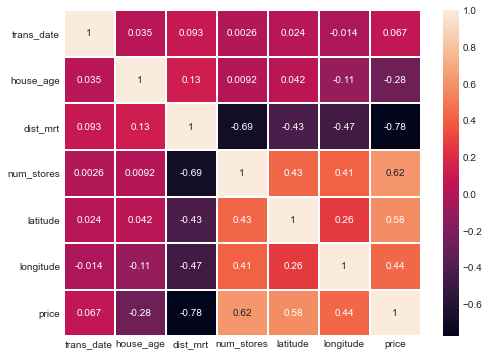

In [10]:
plt.figure(figsize=(8,6))
corr = df.corr(method='spearman')
sns.heatmap(corr, annot=True, linewidths=1);

Create new feature `class` based on the `price`:

In [11]:
df['class'] = [1 if x < 27.7 else 3 if x > 46.6 else 2 for x in df.price]
df['class'] = df['class'].astype("object")
df['class'].value_counts()

2    209
1    103
3    102
Name: class, dtype: int64

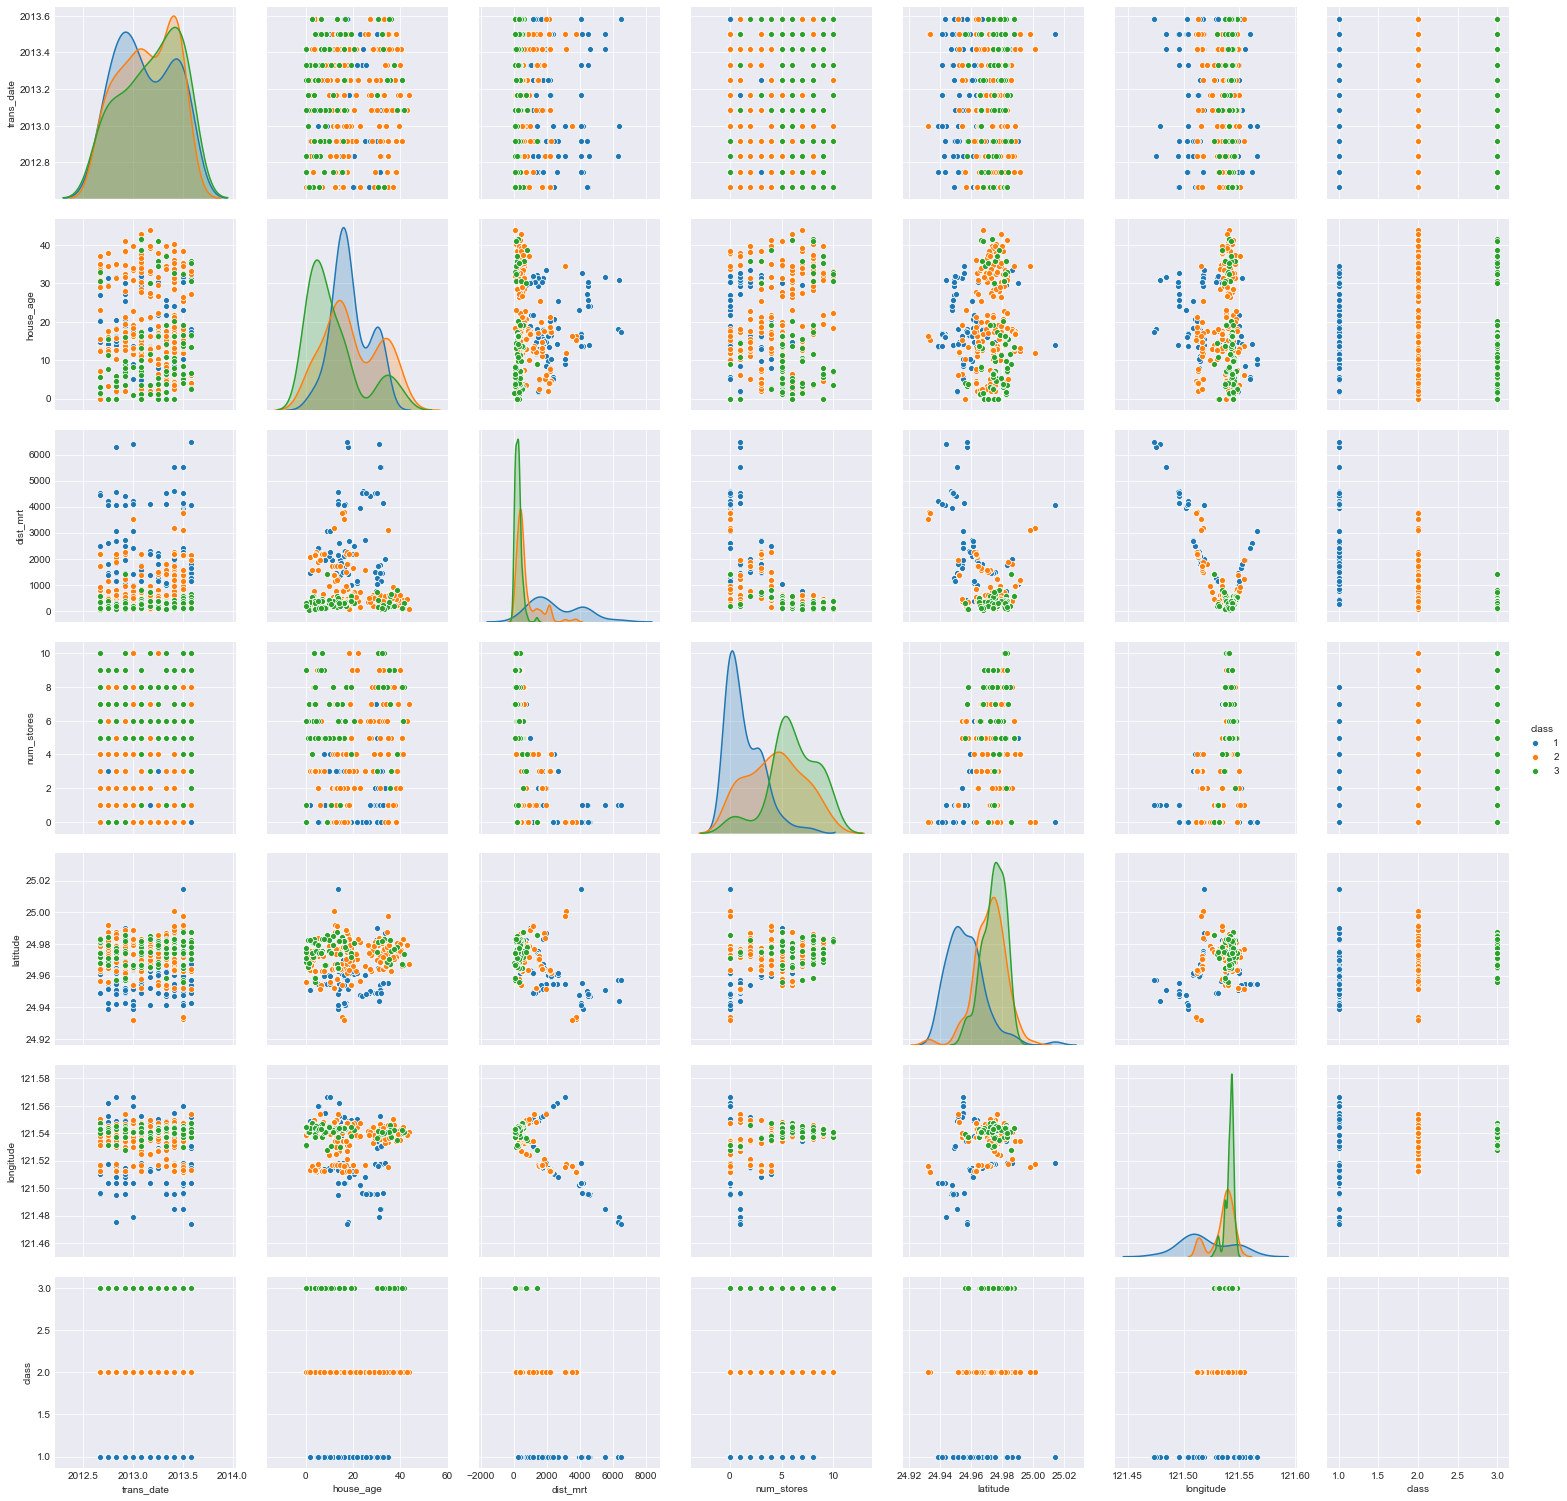

In [13]:
sns.pairplot(df.drop('price', axis=1), hue="class", height=3);

In [14]:
df = df.drop('class', axis=1)

#### ***Visualization (`folium`)***

In [15]:
clear_map = folium.Map(
    location=[25.0,121.5],
    width=500, height=500,
    tiles='Stamen Terrain', 
    zoom_start=11
)
clear_map.save("html/clear_map.html")

Base map:

In [16]:
IFrame(src='html/clear_map.html', width=500, height=500)

In [17]:
price_folium_map(df)

**House price of unit area** - from red (high) to yellow (low):

In [18]:
IFrame(src='html/price_map.html', width=600, height=500)

In [19]:
stores_folium_map(df)

**The number of convenience stores in the living circle on foot** - from red (many) to yellow (few):

In [20]:
IFrame(src='html/stores_map.html', width=600, height=500)

In [21]:
dist_folium_map(df)

**The distance to the nearest MRT station** - from red (near) to yellow (far):

In [22]:
IFrame(src='html/dist_map.html', width=600, height=500)

**Target variable - `price`**

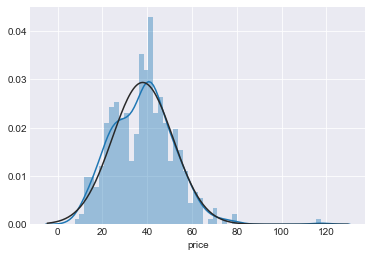

In [10]:
sns.distplot(df.price, fit=norm, bins=50);

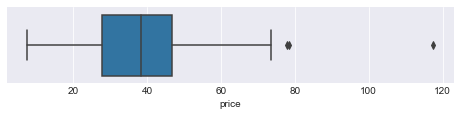

In [11]:
plt.figure(figsize=(8,1.4))
sns.boxplot(df.price);

Observation with max price:

In [12]:
df[df.price==df.price.max()]

,trans_date,house_age,dist_mrt,num_stores,latitude,longitude,price
270,2013.333333,10.8,252.5822,1,24.9746,121.53046,117.5


In [13]:
max_price_map = folium.Map(
    location=[24.966,121.52],
    width=500, height=500,
    tiles='Stamen Terrain', 
    zoom_start=13
)
folium.CircleMarker(location=[24.9746,121.53046], 
                    radius=5, popup = "Max price", 
                    color='red').add_to(max_price_map)
max_price_map.save("html/max_price_map.html")
pass;

In [27]:
IFrame(src='html/max_price_map.html', width=500, height=500)

Available predictors don't explain such a high price so let's remove this observation. 

In [14]:
df = df.drop(df.index[270])

**`house_age`**

In [15]:
(df.house_age == 0).sum()

17

In [16]:
df_house_null = df[df.house_age == 0]
df_house_null.shape

(17, 7)

In [17]:
check_folium_map(df_house_null)

In [32]:
IFrame(src='html/check_map.html', width=500, height=500)

17 observations with `house_age` == **0** belong to 5 objects. Most likely these objects are new buildings with `house_age` less than one year so let's replace their `house_age` values with **0.5**. 

In [18]:
df.house_age = df.house_age.replace(0, 0.5)

In [19]:
df.house_age.value_counts().sort_index()

0.5     17
1.0      1
1.1      5
1.5      2
1.7      1
        ..
40.9     2
41.3     2
41.4     1
42.7     1
43.8     1
Name: house_age, Length: 235, dtype: int64

**`trans_date`**

In [20]:
np.unique(df['trans_date'])

array([2012.6666667, 2012.75     , 2012.8333333, 2012.9166667,
       2013.       , 2013.0833333, 2013.1666667, 2013.25     ,
       2013.3333333, 2013.4166667, 2013.5      , 2013.5833333])

In [21]:
df['trans_date'] = df.trans_date.apply(lambda x: round(x, 1))

In [22]:
gc.collect()

9111

####  Variance Inflation Factor (VIF)

In [45]:
features = list(df.columns)
features

['trans_date',
 'house_age',
 'dist_mrt',
 'num_stores',
 'latitude',
 'longitude',
 'price']

In [51]:
features = features[:-1]
features_df = '+'.join(features)
features_df

'trans_date+house_age+dist_mrt+num_stores+latitude+longitude'

In [52]:
y, X = dmatrices('price ~' + features_df, df, return_type='dataframe')

In [53]:
vif = pd.DataFrame()
vif["VIF Factor"] = [
    variance_inflation_factor(X.values, i) for i in range(X.shape[1])
]
vif["features"] = X.columns

In [54]:
vif.round(1)

,VIF Factor,features
0,244266462.0,Intercept
1,1.0,trans_date
2,1.0,house_age
3,4.4,dist_mrt
4,1.6,num_stores
5,1.6,latitude
6,2.9,longitude


**VIF** for all variables less than 5, so there is no multicollinearity problem.

**Extra preprocessing**

In [55]:
df['year'] = df.trans_date.apply(lambda x: int(x)).astype("category")

# Weird format of 'trans_date'. Add 1 to start month's number with 1 
df['month'] = df.trans_date.apply(
    lambda x: int((x % 1) * 10 + 1)).astype("category")
df = df.drop('trans_date', axis=1)

In [56]:
df.year.value_counts()

2013    287
2012    126
Name: year, dtype: int64

In [57]:
df.month.value_counts()

8     88
3     85
1     74
6     70
5     58
10    38
Name: month, dtype: int64

**`num_stores`**

In [58]:
np.unique(df.num_stores)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64)

In [59]:
df.num_stores = df.num_stores.astype("category")

**Numeric Variables Distribution**

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 413 entries, 0 to 413
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   house_age   413 non-null    float64 
 1   dist_mrt    413 non-null    float64 
 2   num_stores  413 non-null    category
 3   latitude    413 non-null    float64 
 4   longitude   413 non-null    float64 
 5   price       413 non-null    float64 
 6   year        413 non-null    category
 7   month       413 non-null    category
dtypes: category(3), float64(5)
memory usage: 21.3 KB


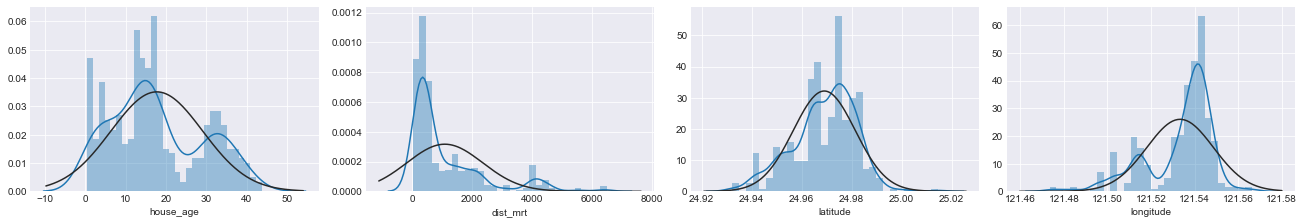

In [61]:
num_cols = ['house_age', 'dist_mrt', 'latitude', 'longitude']
fig, axes = plt.subplots(1, 4, constrained_layout=True, figsize=(18,3))

for i,t in enumerate(num_cols):
    sns.distplot(df[t], fit=norm, bins=30, ax=axes[i % 4])
pass;

In [62]:
train = df.sample(frac=0.7, random_state=42)
test = df.drop(train.index)

In [63]:
train.shape, test.shape

((289, 8), (124, 8))

In [64]:
train_y = train.price
train_X = train.drop('price', axis=1)
test_y = test.price
test_X = test.drop('price', axis=1)

In [65]:
# dist_mrt
train_X["dist_mrt"] = np.log1p(train_X.dist_mrt)
test_X["dist_mrt"] = np.log1p(test_X.dist_mrt)

In [66]:
transform_mm = MinMaxScaler()

In [67]:
train_norm = train_X.copy(deep=True)
train_norm[num_cols] = transform_mm.fit_transform(train_norm[num_cols])

In [68]:
norm_test = pd.DataFrame(index=num_cols, columns=['p_value','dist_type'])
for i in num_cols:
    norm_test.loc[i, ['p_value']] = stats.jarque_bera(train_norm[i])[1]
    if stats.jarque_bera(train_norm[i])[1] >= 0.05:
        norm_test.loc[i, ['dist_type']] = 'normal'
    else:
        norm_test.loc[i, ['dist_type']] = 'not normal'
        
norm_test  

,p_value,dist_type
house_age,0.000228355,not normal
dist_mrt,0.233039,normal
latitude,0.00926976,not normal
longitude,0,not normal


In [69]:
_, transformed_p = normaltest(train_norm[num_cols])
list(transformed_p)

[7.745189916821765e-09,
 0.1150311847544267,
 0.009599275793006425,
 1.133392285040297e-15]

In [70]:
num_cols = [i for i in train_X.columns if 
               train_X[i].dtype.name=='float64']
cat_cols = [i for i in train_X.columns if 
               train_X[i].dtype.name=='category']

In [71]:
train_X_num = train_X[num_cols]
transform_mm.fit(train_X_num)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [72]:
del train_X_num

In [73]:
def preproc(data, trans):
    data_cat = pd.get_dummies(data[cat_cols])
    data_norm = data[num_cols]
    data_norm[num_cols] = trans.transform(data[num_cols])
    data_all = pd.concat((data_norm, data_cat), axis=1)
    return data_all 

In [74]:
X_train_alfa = preproc(train_X, transform_mm)
X_test_alfa = preproc(test_X, transform_mm)

In [99]:
X_train_alfa.head()
X_train_alfa.shape

,house_age,dist_mrt,latitude,longitude,num_stores_0,num_stores_1,num_stores_2,num_stores_3,num_stores_4,num_stores_5,num_stores_6,num_stores_7,num_stores_8,num_stores_9,num_stores_10,year_2012,year_2013,month_1,month_3,month_5,month_6,month_8,month_10
395,0.478060,0.545751,0.508119,0.735631,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
350,0.293303,0.538522,0.400873,0.723727,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0
401,0.163972,0.804332,0.375424,0.442240,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
354,0.270208,0.720309,0.242002,0.848997,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
181,0.256351,0.379443,0.640087,0.767260,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0


(289, 23)

In [76]:
gc.collect()

7268

### Modeling

In [77]:
regr = LinearRegression()
lr_model = regr.fit(X_train_alfa, train_y)

In [80]:
pred_y = lr_model.predict(X_test_alfa)

print('Coefficients: \n', regr.coef_, '\n')
print('Mean squared error: %.2f \n'
      % mean_squared_error(test_y, pred_y))
print('Coefficient of determination: %.3f'
      % r2_score(test_y, pred_y))

Coefficients: 
 [ -9.5669201  -29.7031207   22.23937422   4.94106445  -2.27547841
  -3.8290539   -2.19291946  -3.29680408   0.10971204   1.64004134
   1.68984775  -0.25619885   4.24665646   4.6513694   -0.48717228
  -1.09840627   1.09840627  -0.38583096  -0.33909118  -1.94755422
   3.77088263  -0.56152429  -0.53688199] 

Mean squared error: 52.97 

Coefficient of determination: 0.711


#### Extra Features Generation (Associations rules learning)

The necessary step is a binning of numeric variables. When splitting, we are guided by the quantiles values. Bin boundaries are ***-infinity*** and ***+infinity***.

In [110]:
dist = train_X[num_cols].describe()
dist

,house_age,dist_mrt,latitude,longitude
count,289.000000,289.000000,289.000000,289.000000
mean,17.882699,6.367756,24.968765,121.533449
std,11.443929,1.124761,0.012386,0.015239
min,0.500000,3.193880,24.932070,121.473530
25%,9.100000,5.671000,24.962990,121.529810
50%,16.100000,6.200978,24.970260,121.538890
75%,28.600000,7.278136,24.977440,121.543310
max,43.800000,8.777867,25.014590,121.561740


In [111]:
bin_list = []
for i in num_cols:
    bin = [-np.inf, round(dist.iloc[4][i], 5), 
           round(dist.iloc[5][i], 5), 
           round(dist.iloc[6][i], 5), np.inf]
    bin_list.append(bin)

In [112]:
bin_list

[[-inf, 9.1, 16.1, 28.6, inf],
 [-inf, 5.671, 6.20098, 7.27814, inf],
 [-inf, 24.96299, 24.97026, 24.97744, inf],
 [-inf, 121.52981, 121.53889, 121.54331, inf]]

In [113]:
train_X_bin = train_X[num_cols]
test_X_bin = test_X[num_cols]

In [114]:
for k, i in enumerate(num_cols):
    train_X_bin[f'{i}_bin'] = pd.cut(train_X[i], bins=bin_list[k])
    test_X_bin[f'{i}_bin'] = pd.cut(test_X[i], bins=bin_list[k])       

In [115]:
train_X_bin = train_X_bin.select_dtypes(include = ['category'])
test_X_bin = test_X_bin.select_dtypes(include = ['category'])

In [116]:
train_X_bin

,house_age_bin,dist_mrt_bin,latitude_bin,longitude_bin
395,"(16.1, 28.6]","(6.201, 7.278]","(24.97, 24.977]","(121.53, 121.539]"
350,"(9.1, 16.1]","(5.671, 6.201]","(24.963, 24.97]","(121.53, 121.539]"
401,"(-inf, 9.1]","(7.278, inf]","(24.963, 24.97]","(-inf, 121.53]"
354,"(9.1, 16.1]","(6.201, 7.278]","(-inf, 24.963]","(121.543, inf]"
181,"(9.1, 16.1]","(-inf, 5.671]","(24.977, inf]","(121.539, 121.543]"
...,...,...,...,...
41,"(16.1, 28.6]","(7.278, inf]","(-inf, 24.963]","(-inf, 121.53]"
322,"(9.1, 16.1]","(-inf, 5.671]","(24.97, 24.977]","(121.53, 121.539]"
206,"(16.1, 28.6]","(5.671, 6.201]","(24.977, inf]","(121.53, 121.539]"
283,"(28.6, inf]","(7.278, inf]","(24.977, inf]","(-inf, 121.53]"


In [218]:
train_X_b = pd.concat((train_X[cat_cols], train_X_bin), axis=1)
test_X_b = pd.concat((test_X[cat_cols], test_X_bin), axis=1)

In [219]:
train_X_b.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 289 entries, 395 to 254
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   num_stores     289 non-null    category
 1   year           289 non-null    category
 2   month          289 non-null    category
 3   house_age_bin  289 non-null    category
 4   dist_mrt_bin   289 non-null    category
 5   latitude_bin   289 non-null    category
 6   longitude_bin  289 non-null    category
dtypes: category(7)
memory usage: 5.8 KB


In [220]:
train_X_b.head()

,num_stores,year,month,house_age_bin,dist_mrt_bin,latitude_bin,longitude_bin
395,4,2012,10,"(16.1, 28.6]","(6.201, 7.278]","(24.97, 24.977]","(121.53, 121.539]"
350,5,2013,1,"(9.1, 16.1]","(5.671, 6.201]","(24.963, 24.97]","(121.53, 121.539]"
401,3,2013,1,"(-inf, 9.1]","(7.278, inf]","(24.963, 24.97]","(-inf, 121.53]"
354,1,2013,5,"(9.1, 16.1]","(6.201, 7.278]","(-inf, 24.963]","(121.543, inf]"
181,8,2013,3,"(9.1, 16.1]","(-inf, 5.671]","(24.977, inf]","(121.539, 121.543]"


In [221]:
train_X_arl = pd.get_dummies(train_X_b)
test_X_arl = pd.get_dummies(test_X_b)

In [222]:
train_X_arl.head()
train_X_arl.shape

,num_stores_0,num_stores_1,num_stores_2,num_stores_3,num_stores_4,num_stores_5,num_stores_6,num_stores_7,num_stores_8,num_stores_9,num_stores_10,year_2012,year_2013,month_1,month_3,month_5,month_6,month_8,month_10,"house_age_bin_(-inf, 9.1]","house_age_bin_(9.1, 16.1]","house_age_bin_(16.1, 28.6]","house_age_bin_(28.6, inf]","dist_mrt_bin_(-inf, 5.671]","dist_mrt_bin_(5.671, 6.201]","dist_mrt_bin_(6.201, 7.278]","dist_mrt_bin_(7.278, inf]","latitude_bin_(-inf, 24.963]","latitude_bin_(24.963, 24.97]","latitude_bin_(24.97, 24.977]","latitude_bin_(24.977, inf]","longitude_bin_(-inf, 121.53]","longitude_bin_(121.53, 121.539]","longitude_bin_(121.539, 121.543]","longitude_bin_(121.543, inf]"
395,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0
350,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0
401,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0
354,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1
181,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0


(289, 35)

**Apriori**

In [234]:
apr = apriori(train_X_arl, min_support=0.22, use_colnames=True)
apr = apr.sort_values('support', ascending=False)
apr

,support,itemsets
1,0.688581,(year_2013)
0,0.311419,(year_2012)
7,0.280277,"(dist_mrt_bin_(5.671, 6.201])"
10,0.266436,"(latitude_bin_(-inf, 24.963])"
3,0.252595,"(house_age_bin_(9.1, 16.1])"
2,0.252595,"(house_age_bin_(-inf, 9.1])"
15,0.252595,"(longitude_bin_(121.53, 121.539])"
5,0.249135,"(house_age_bin_(28.6, inf])"
9,0.249135,"(dist_mrt_bin_(7.278, inf])"
12,0.249135,"(latitude_bin_(24.97, 24.977])"


Association rules based on `confidence` metric.

In [235]:
rules = association_rules(apr, metric="confidence", min_threshold=0.3)
rules.sort_values(by=['confidence'], ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
2,"(longitude_bin_(-inf, 121.53])","(dist_mrt_bin_(7.278, inf])",0.249135,0.249135,0.224913,0.902778,3.623650,0.162845,7.723183
3,"(dist_mrt_bin_(7.278, inf])","(longitude_bin_(-inf, 121.53])",0.249135,0.249135,0.224913,0.902778,3.623650,0.162845,7.723183
1,"(dist_mrt_bin_(5.671, 6.201])",(year_2013),0.280277,0.688581,0.224913,0.802469,1.165395,0.031920,1.576557
0,(year_2013),"(dist_mrt_bin_(5.671, 6.201])",0.688581,0.280277,0.224913,0.326633,1.165395,0.031920,1.068843


Extra features based on binning (except data transaction features that already exist):

In [236]:
apr = apr[2:]
apr = apr.reset_index()

In [237]:
apr_set = apr[-2:]
apr = apr[:-2]
apr_set

,index,support,itemsets
16,18,0.224913,"(year_2013, dist_mrt_bin_(5.671, 6.201])"
17,19,0.224913,"(longitude_bin_(-inf, 121.53], dist_mrt_bin_(7..."


In [238]:
apr.itemsets = [list(x) for x in apr.itemsets]
arl_list = list(apr.itemsets.values)

In [239]:
set_ones_arl = list(itertools.chain.from_iterable(arl_list))
set_ones_arl

['dist_mrt_bin_(5.671, 6.201]',
 'latitude_bin_(-inf, 24.963]',
 'house_age_bin_(9.1, 16.1]',
 'house_age_bin_(-inf, 9.1]',
 'longitude_bin_(121.53, 121.539]',
 'house_age_bin_(28.6, inf]',
 'dist_mrt_bin_(7.278, inf]',
 'latitude_bin_(24.97, 24.977]',
 'latitude_bin_(24.977, inf]',
 'longitude_bin_(-inf, 121.53]',
 'longitude_bin_(121.539, 121.543]',
 'longitude_bin_(121.543, inf]',
 'house_age_bin_(16.1, 28.6]',
 'dist_mrt_bin_(-inf, 5.671]',
 'latitude_bin_(24.963, 24.97]',
 'dist_mrt_bin_(6.201, 7.278]']

In [240]:
train_X_first = train_X_arl[set_ones_arl]
test_X_first = test_X_arl[set_ones_arl]

New features based on association rules:

In [241]:
apr_set.itemsets = [list(x) for x in apr_set.itemsets]
apr_set_list = list(apr_set.itemsets.values)

In [242]:
set_two_arl = list(itertools.chain.from_iterable(apr_set_list))
set_two_arl

['year_2013',
 'dist_mrt_bin_(5.671, 6.201]',
 'longitude_bin_(-inf, 121.53]',
 'dist_mrt_bin_(7.278, inf]']

In [243]:
train_X_second = train_X_arl[set_two_arl]
test_X_second = test_X_arl[set_two_arl]

In [244]:
train_X_second[
    'year_2013_dist_mrt_bin_1'] = train_X_second['year_2013'] + train_X_second['dist_mrt_bin_(5.671, 6.201]']
train_X_second[
    'long_bin_1_dist_mrt_bin_3'] = train_X_second['longitude_bin_(-inf, 121.53]'] + train_X_second['dist_mrt_bin_(7.278, inf]']

test_X_second[
    'year_2013_dist_mrt_bin_1'] = test_X_second['year_2013'] + test_X_second['dist_mrt_bin_(5.671, 6.201]']
test_X_second[
    'long_bin_1_dist_mrt_bin_3'] = test_X_second['longitude_bin_(-inf, 121.53]'] + test_X_second['dist_mrt_bin_(7.278, inf]']

In [245]:
train_X_second = train_X_second[['year_2013_dist_mrt_bin_1',
                               'long_bin_1_dist_mrt_bin_3']]
test_X_second = test_X_second[['year_2013_dist_mrt_bin_1',
                               'long_bin_1_dist_mrt_bin_3']]
train_X_second.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 289 entries, 395 to 254
Data columns (total 2 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   year_2013_dist_mrt_bin_1   289 non-null    uint8
 1   long_bin_1_dist_mrt_bin_3  289 non-null    uint8
dtypes: uint8(2)
memory usage: 2.8 KB


In [246]:
train_X_second['year_2013_dist_mrt_bin_1'] = train_X_second[
    'year_2013_dist_mrt_bin_1'].astype('category')
train_X_second['long_bin_1_dist_mrt_bin_3'] = train_X_second[
    'long_bin_1_dist_mrt_bin_3'].astype('category')

test_X_second['year_2013_dist_mrt_bin_1'] = test_X_second[
    'year_2013_dist_mrt_bin_1'].astype('category')
test_X_second['long_bin_1_dist_mrt_bin_3'] = test_X_second[
    'long_bin_1_dist_mrt_bin_3'].astype('category')

In [247]:
train_X_second = pd.get_dummies(train_X_second)
test_X_second = pd.get_dummies(test_X_second)

In [248]:
test_X_second.shape

(124, 6)

In [249]:
train_X_add = pd.concat((train_X_first, train_X_second), axis=1)
test_X_add = pd.concat((test_X_first, test_X_second), axis=1)

In [250]:
train_X_add.shape
test_X_add.shape

(289, 22)

(124, 22)

In [251]:
# All together
X_train_all = pd.concat((X_train_alfa, train_X_add), axis=1)
X_test_all = pd.concat((X_test_alfa, test_X_add), axis=1)

In [252]:
X_train_all.shape
X_train_all.head()

(289, 45)

,house_age,dist_mrt,latitude,longitude,num_stores_0,num_stores_1,num_stores_2,num_stores_3,num_stores_4,num_stores_5,num_stores_6,num_stores_7,num_stores_8,num_stores_9,num_stores_10,year_2012,year_2013,month_1,month_3,month_5,...,"house_age_bin_(9.1, 16.1]","house_age_bin_(-inf, 9.1]","longitude_bin_(121.53, 121.539]","house_age_bin_(28.6, inf]","dist_mrt_bin_(7.278, inf]","latitude_bin_(24.97, 24.977]","latitude_bin_(24.977, inf]","longitude_bin_(-inf, 121.53]","longitude_bin_(121.539, 121.543]","longitude_bin_(121.543, inf]","house_age_bin_(16.1, 28.6]","dist_mrt_bin_(-inf, 5.671]","latitude_bin_(24.963, 24.97]","dist_mrt_bin_(6.201, 7.278]",year_2013_dist_mrt_bin_1_0,year_2013_dist_mrt_bin_1_1,year_2013_dist_mrt_bin_1_2,long_bin_1_dist_mrt_bin_3_0,long_bin_1_dist_mrt_bin_3_1,long_bin_1_dist_mrt_bin_3_2
395,0.478060,0.545751,0.508119,0.735631,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0
350,0.293303,0.538522,0.400873,0.723727,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,...,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0
401,0.163972,0.804332,0.375424,0.442240,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,...,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1
354,0.270208,0.720309,0.242002,0.848997,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,...,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0
181,0.256351,0.379443,0.640087,0.767260,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,...,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0


In [253]:
gc.collect()

164

### Modeling with Extra Features

In [254]:
regr = LinearRegression()
lr_model = regr.fit(X_train_all, train_y)

In [256]:
pred_y = lr_model.predict(X_test_all)

print('Coefficients: \n', regr.coef_, '\n')
print('Mean squared error: %.2f \n'
      % mean_squared_error(test_y, pred_y))
print('R2: %.3f'
      % r2_score(test_y, pred_y))

Coefficients: 
 [-4.38818552e+00 -2.71331841e+01 -1.14516485e+01  9.86828327e+00
  4.30712798e+12  4.30712798e+12  4.30712798e+12  4.30712798e+12
  4.30712798e+12  4.30712798e+12  4.30712798e+12  4.30712798e+12
  4.30712798e+12  4.30712798e+12  4.30712798e+12 -1.28738137e+13
 -1.07539947e+13  3.58424989e+12  3.58424989e+12  3.58424989e+12
  3.58424989e+12  2.07154764e+12  2.07154764e+12  3.14731456e+11
 -3.51154323e+12  4.43263363e+12  4.43263363e+12 -5.31830725e+12
  4.43263363e+12 -1.07093227e+13 -3.51154323e+12 -3.51154323e+12
 -1.27098402e+13 -5.31830725e+12 -5.31830725e+12  4.43263363e+12
 -3.31778976e+12 -3.51154323e+12 -3.31778976e+12  1.37531665e+12
 -2.25720456e+12 -5.88972578e+12 -9.75907632e+12 -2.36754337e+12
  5.02398958e+12] 

Mean squared error: 48.31 

R2: 0.737


**LinearRegression** with extra features:
* `Mean squared error` decreased from **52.97** to **48.32**.
* `R2` increased from **0.711*** to **to 0.737**.

**RandomForestRegressor**

In [261]:
rf = RandomForestRegressor(n_estimators=600, random_state=42)
rf.fit(X_train_alfa, train_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=600,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [262]:
pred_rf_y = rf.predict(X_test_alfa)

print('Mean squared error: %.2f \n'
      % mean_squared_error(test_y, pred_rf_y))
print('R2: %.3f'
      % r2_score(test_y, pred_rf_y))

Mean squared error: 31.12 

R2: 0.830


**RandomForestRegressor with extra features**

In [263]:
rf = RandomForestRegressor(n_estimators=600, random_state=42)
rf.fit(X_train_all, train_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=600,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [264]:
pred_rf_y = rf.predict(X_test_all)

print('Mean squared error: %.2f \n'
      % mean_squared_error(test_y, pred_rf_y))
print('R2: %.3f'
      % r2_score(test_y, pred_rf_y))

Mean squared error: 30.85 

R2: 0.832
